In [1]:
import subprocess as sp
import shapely
import xarray as xr
import rasterio
import matplotlib
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from io import StringIO
from sklearn import tree, model_selection
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

from sklearn.model_selection import GridSearchCV
import pandas as pd
from collections import Counter, defaultdict

In [35]:
#Recursive Feature Elimination
feature_selection_counts = Counter()

#Requires a set of 20 .csv files for both training and validation.
#First column as target feature.
for i in range(1, 21):
    train_df = pd.read_csv(f"training_df_1_{i}.csv")
    X_train = train_df.iloc[:, 1:]
    y_train = train_df.iloc[:, 0]
    #Classification parameters.
    model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=16)
    #Select 10 features for full-feature model and 5 for chl-a model.
    rfe = RFE(estimator=model, n_features_to_select=10)
    rfe.fit(X_train, y_train)

    selected_features = X_train.columns[rfe.support_]
    feature_selection_counts.update(selected_features)

# Show features most frequently selected
top_features = feature_selection_counts.most_common()
print("Top features across all RFE runs:")
for feature, count in top_features:
    print(f"{feature}: selected in {count}/20 runs")

Top features across all RFE runs:
chlor_a: selected in 20/20 runs
timestep: selected in 20/20 runs
Depth: selected in 20/20 runs
PRODWARN: selected in 19/20 runs
ATMWARN: selected in 18/20 runs
COASTZ: selected in 2/20 runs
HIPOL: selected in 1/20 runs


In [ ]:
#Average Gini importance for all features.

# Store frequency of selection and total importance
feature_selection_counts = Counter()
feature_importance_sums = defaultdict(float)

#Same model set-up as above
for i in range(1, 21):
    train_df = pd.read_csv(f"training_df_1_{i}.csv")
    X_train = train_df.iloc[:, 1:]
    y_train = train_df.iloc[:, 0]

    model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=16)
    rfe = RFE(estimator=model, n_features_to_select=10)
    rfe.fit(X_train, y_train)

    # Get selected features
    selected_features = X_train.columns[rfe.support_]
    feature_selection_counts.update(selected_features)

    # Get Gini importances from the fitted estimator
    importances = rfe.estimator_.feature_importances_
    for feature, importance in zip(selected_features, importances):
        feature_importance_sums[feature] += importance

# Build summary table
summary = []
for feature in feature_selection_counts:
    count = feature_selection_counts[feature]
    total_importance = feature_importance_sums[feature]
    avg_importance = total_importance / count
    summary.append((feature, count, round(avg_importance, 4)))

# Rank by inclusions, then importance
summary_sorted = sorted(summary, key=lambda x: (-x[1], -x[2]))
print(f"{'Feature':<25} {'Selected (n)':<12} {'Avg Gini Importance'}")
for feature, count, avg_imp in summary_sorted:
    print(f"{feature:<25} {count:<12} {avg_imp}")


In [2]:
sample_correctness = defaultdict(list)

In [12]:
#Iterate training and validation for 20 datasets, and return average results.
f1_scores = []
kappa_scores = []
conf_matrices = []
accuracy_scores = []

# Loop through the 20 datasets
for i in range(1, 21):
    # Load training and validation data
    train_path = f"training_df_32_{i}.csv"
    val_path = f"validation_df_32_{i}.csv"

    training_df = pd.read_csv(train_path, encoding='latin1')
    validation_df = pd.read_csv(val_path, encoding='latin1')

    column_names = training_df.columns.tolist()
    model_variables = column_names[1:]
    model_col_indices = [column_names.index(var_name) for var_name in model_variables]

    # Define model consistent with RFE
    model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=16)
    model.fit(training_df.iloc[:, model_col_indices], training_df.iloc[:, 0])

    # Predict on validation dataset
    predictions = model.predict(validation_df.iloc[:, model_col_indices])

    for j in range(len(validation_df.iloc[:, 0].astype(str))):
            depth = validation_df.iloc[j]['Depth']
            true_val = validation_df.iloc[j, 0]
            pred_val = predictions[j]
            correct = int(pred_val == true_val)
            sample_correctness[depth].append(correct)

    # Generate metrics
    acc = accuracy_score(validation_df.iloc[:, 0], predictions)
    f1 = f1_score(validation_df.iloc[:, 0], predictions, average='weighted')
    kappa = cohen_kappa_score(validation_df.iloc[:, 0], predictions)
    cm = confusion_matrix(validation_df.iloc[:, 0], predictions)
    accuracy_scores.append(acc)
    f1_scores.append(f1)
    kappa_scores.append(kappa)
    conf_matrices.append(cm)

# Average confusion matrices
conf_matrices = np.array(conf_matrices)
mean_conf_matrix = np.mean(conf_matrices, axis=0)

# Summarise metrics
results_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score (weighted)', 'Cohen Kappa'],
    'Mean': [
        np.mean(accuracy_scores),
        np.mean(f1_scores),
        np.mean(kappa_scores)
    ],
    'StdDev': [
        np.std(accuracy_scores),
        np.std(f1_scores),
        np.std(kappa_scores)
    ]
})

#Output metrics and confusion matrix
print("=== Performance Metrics (Mean ± SD) ===")
print(results_summary.round(4))
print("\n=== Mean Confusion Matrix ===")
print(mean_conf_matrix.round(2))

=== Performance Metrics (Mean ± SD) ===
                Metric    Mean  StdDev
0             Accuracy  0.5900  0.0225
1  F1 Score (weighted)  0.5723  0.0217
2          Cohen Kappa  0.4383  0.0301

=== Mean Confusion Matrix ===
[[13.5   4.2   0.5   0.    1.  ]
 [ 3.9   5.65  0.6   0.05  2.9 ]
 [ 0.4   1.   23.05  7.8  10.45]
 [ 0.15  0.   14.15  6.05  7.65]
 [ 1.95  1.55  7.    2.4  49.1 ]]


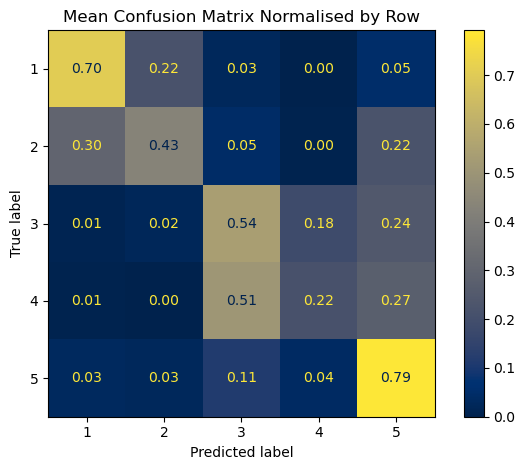

In [13]:
#Plot confusion matrix normalised by row
class_labels = sorted(np.unique(validation_df.iloc[:, 0]))
mean_conf_matrix_row_norm = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix_row_norm, display_labels=class_labels)
disp.plot(cmap='cividis', values_format=".2f")
plt.title("Mean Confusion Matrix Normalised by Row")
plt.tight_layout()
plt.savefig("confusion_matrix_row_chla.png")
plt.show()

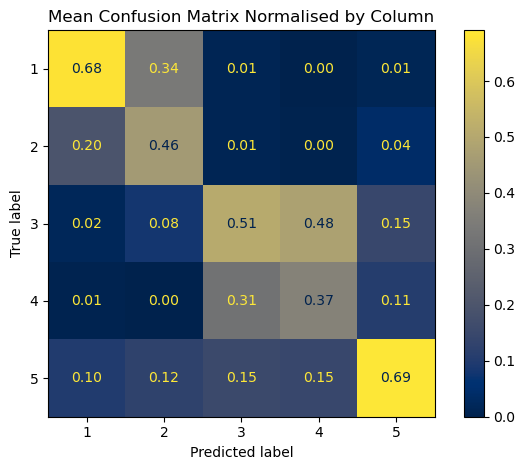

In [14]:
#Plot confusion matrix normalised by column
class_labels = sorted(np.unique(validation_df.iloc[:, 0]))
mean_conf_matrix_col_norm = mean_conf_matrix / mean_conf_matrix.sum(axis=0, keepdims=True)
disp = ConfusionMatrixDisplay(confusion_matrix=mean_conf_matrix_col_norm, display_labels=class_labels)
disp.plot(cmap='cividis', values_format=".2f")
plt.title("Mean Confusion Matrix Normalised by Column")
plt.tight_layout()
plt.savefig("confusion_matrix_col_chla.png")
plt.show()